In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
from pathlib import Path

## Plot 2D heatmap

In [ ]:
def plot_lattice(filename):
    lattice = np.loadtxt(filename)

    plt.figure(figsize=(6, 6))
    plt.imshow(lattice,
               cmap="bwr",
               origin="lower",
               vmin=-1,
               vmax=1)
    plt.colorbar(label="Spin value")
    plt.title("2D Ising Lattice")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()

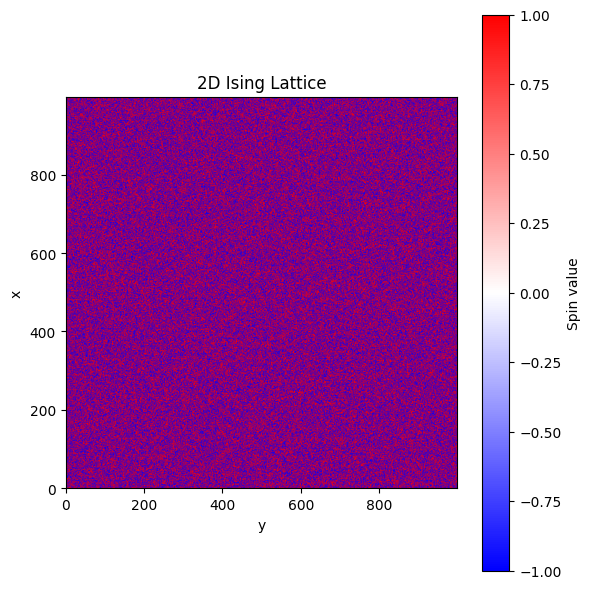

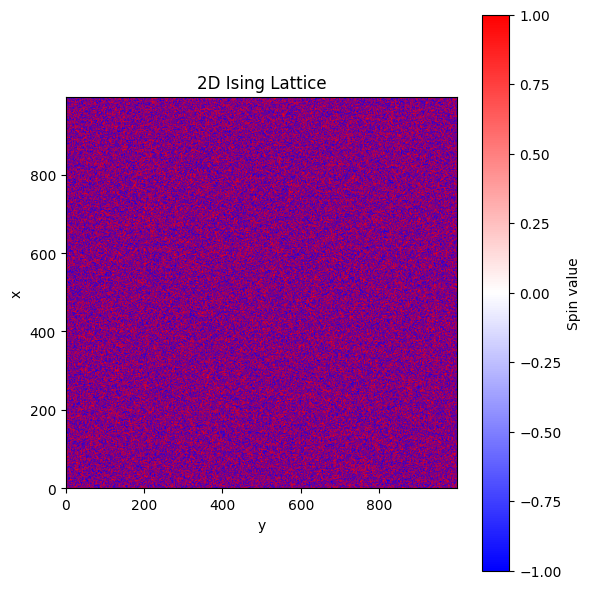

In [ ]:
plot_lattice("data/ising_J3.000_h0.306_T100.000_Lx1000_Ly1000_MC0_type3.dat")
plot_lattice("data/ising_J3.000_h0.306_T100.000_Lx1000_Ly1000_MC10000000_type3.dat")

# Magnetization plots

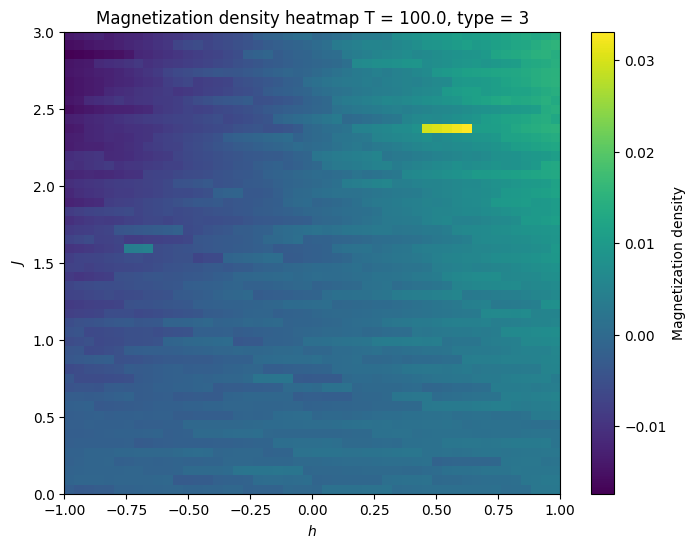

In [68]:
# Read the magnetization csv file

L = 1000
T = 100.0
type = 3

filename = f"data/magnetization{L}_{L}_T{T}00_type{type}.csv"

magnetization = pd.read_csv(filename)

heatmap_df = magnetization.pivot(
    index="J",
    columns="h",
    values="magnetization_density"
)

plt.figure(figsize=(8, 6))

im = plt.imshow(
    heatmap_df.values,
    origin="lower",
    aspect="auto",
    extent=[heatmap_df.columns.min(), heatmap_df.columns.max(), heatmap_df.index.min(), heatmap_df.index.max()]
)

plt.colorbar(im, label="Magnetization density")
plt.xlabel(r"$h$")
plt.ylabel(r"$J$")
plt.title(f"Magnetization density heatmap T = {T}, type = {type}")

plt.show()

# Data Analysi

In [20]:
def load_and_merge_csv(folder_path, ignore = None):
    """
    Load all .csv files in a folder and merge them into a single DataFrame.

    Parameters
    ----------
    folder_path : str or Path
        Path to the folder containing CSV files.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame.
    """
    folder = Path(folder_path)
    csv_files = sorted(folder.glob("*.csv"))

    if not csv_files:
        raise ValueError(f"No CSV files found in {folder}")

    if ignore is not None:
        csv_files = [f for f in csv_files if ignore not in f.name]

    dfs = [pd.read_csv(f) for f in csv_files]
    df_merged = pd.concat(dfs, ignore_index=True)

    return df_merged

In [20]:
folder = "results"
fname = "ising_results_20260206_161554new.csv"

df = load_and_merge_csv(folder, fname)
df

,backend,L,init_type,J,h,T,n_steps,E,e_density,m,m_density,init_time,mh_time,mh_time_per_step
0,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000010,0.039684,3.968400e-07
1,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000008,0.039670,3.967000e-07
2,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000007,0.039665,3.966500e-07
3,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000007,0.039659,3.965900e-07
4,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,1.000000,0.000007,0.039658,3.965800e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18544492.0,-1.105338,6384640.0,0.380554,0.000160,0.000164,9.775162e-12
5936,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18519540.0,-1.103851,6379226.0,0.380231,0.000146,0.000184,1.096725e-11
5937,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18547624.0,-1.105525,6382494.0,0.380426,0.000147,0.000192,1.144409e-11
5938,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18547624.0,-1.105525,6382494.0,0.380426,0.000167,0.000166,9.894371e-12


Group the time results avereging on the same backend, L, init_type, J, h, T, n_steps

In [6]:
def plot_avg_performance(
    df: pd.DataFrame,
    *,
    L=None,
    T=None,
    J=None,
    h=None,
    init_type=None,
    n_steps=None,
    metric="mh_time_per_step",
    backends=("cpu_1", "cpu_openmp", "gpu", "gpu_efficient"),
    logy=True,
):
    """
    Plot average performance for selected parameters, grouped by backend.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    L, T, J, h, init_type, n_steps : optional
        If provided, filter dataframe by these values.
    metric : str
        Column to average and plot (default: 'mh_time_per_step').
    backends : tuple
        Backends to include.
    logy : bool
        Use logarithmic y-scale.
    """

    # --- filtering ---
    mask = pd.Series(True, index=df.index)

    if L is not None:
        mask &= df["L"] == L
    if T is not None:
        mask &= df["T"] == T
    if J is not None:
        mask &= df["J"] == J
    if h is not None:
        mask &= df["h"] == h
    if init_type is not None:
        mask &= df["init_type"] == init_type
    if n_steps is not None:
        mask &= df["n_steps"] == n_steps

    df_filt = df.loc[mask & df["backend"].isin(backends)]

    if df_filt.empty:
        raise ValueError("No data left after filtering.")

    # --- aggregation ---
    avg = (
        df_filt
        .groupby("backend", sort=False)[metric]
        .mean()
        .reindex(backends)
    )

    # --- plotting ---
    plt.figure(figsize=(7, 4))
    avg.plot(kind="bar")

    plt.ylabel(f"Average {metric}")
    plt.xlabel("Backend")

    title_parts = []
    for name, val in [("L", L), ("T", T), ("J", J), ("h", h), ("init", init_type)]:
        if val is not None:
            title_parts.append(f"{name}={val}")

    if title_parts:
        plt.title(", ".join(title_parts))
    else:
        plt.title("Average performance by backend")

    if logy:
        plt.yscale("log")

    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [47]:
def filter_physical_energy_magnetization(df, tol=1e-6, verbose=True):
    df = df.copy()
    df["N"] = df["L"] * df["L"]

    # -----------------------------
    # 1. Absolute bounds
    # -----------------------------
    df["ok_m"] = np.abs(df["m"]) <= df["N"] + tol
    df["ok_md"] = np.abs(df["m_density"]) <= 1 + tol

    df["ok_E_density"] = np.abs(
        df["E"] - df["e_density"] * df["N"]
    ) <= tol*np.sqrt(df["N"])

    # -----------------------------
    # 2. Theoretical energy bounds
    # -----------------------------
    df["E_min"] = -2 * df["J"] * df["N"] - np.abs(df["h"]) * df["N"]
    df["E_max"] =  2 * df["J"] * df["N"] + np.abs(df["h"]) * df["N"]

    df["ok_E_bounds"] = (
        (df["E"] >= df["E_min"] - tol) &
        (df["E"] <= df["E_max"] + tol)
    )

    # -----------------------------
    # 3. HM equilibrium sanity check
    # Energy ↔ magnetization coherence
    # -----------------------------
    # Normalized quantities
    df["E_norm"] = (df["E"] - df["E_min"]) / (df["E_max"] - df["E_min"] + tol)
    df["m_abs"] = np.abs(df["m_density"])

    # If energy is very low → magnetization must be high
    low_E = df["E_norm"] < 0.2
    df["ok_lowE"] = True
    df.loc[low_E, "ok_lowE"] = df.loc[low_E, "m_abs"] > 0.3

    # If energy is very high → magnetization must be low
    high_E = df["E_norm"] > 0.8
    df["ok_highE"] = True
    df.loc[high_E, "ok_highE"] = df.loc[high_E, "m_abs"] < 0.7

    # -----------------------------
    # Final mask
    # -----------------------------
    checks = [
        "ok_m",
        "ok_md",
        "ok_E_density",
        "ok_E_bounds",
        "ok_lowE",
        "ok_highE",
    ]

    df["is_physical"] = df[checks].all(axis=1)

    df_clean = df[df["is_physical"]].copy()
    df_rejected = df[~df["is_physical"]].copy()

    if verbose:
        print("\n=== Energy & Magnetization Physical Filter ===")
        print(f"Total rows    : {len(df)}")
        print(f"Accepted      : {len(df_clean)}")
        print(f"Rejected      : {len(df_rejected)}")

        print("\nRejection causes:")
        for c in checks:
            n = (~df[c]).sum()
            if n > 0:
                print(f"  {c:14s}: {n}")

    return df_clean, df_rejected


In [48]:
df_clean, df_bad = filter_physical_energy_magnetization(df, 0.1)


=== Energy & Magnetization Physical Filter ===
Total rows    : 5940
Accepted      : 5910
Rejected      : 30

Rejection causes:
  ok_E_bounds   : 30


In [49]:
df_bad

,backend,L,init_type,J,h,T,n_steps,E,e_density,m,...,ok_md,ok_E_density,E_min,E_max,ok_E_bounds,E_norm,m_abs,ok_lowE,ok_highE,is_physical
1365,cpu_1,2560,all_up,1.0,1.0,0.5,100000,-20621992.0,-3.146666,6553600.0,...,True,True,-19660800.0,19660800.0,False,-0.024444,1.000000,True,True,False
1366,cpu_1,2560,all_up,1.0,1.0,0.5,100000,-20621992.0,-3.146666,6553600.0,...,True,True,-19660800.0,19660800.0,False,-0.024444,1.000000,True,True,False
1367,cpu_1,2560,all_up,1.0,1.0,0.5,100000,-20621992.0,-3.146666,6553600.0,...,True,True,-19660800.0,19660800.0,False,-0.024444,1.000000,True,True,False
1368,cpu_1,2560,all_up,1.0,1.0,0.5,100000,-20621992.0,-3.146666,6553600.0,...,True,True,-19660800.0,19660800.0,False,-0.024444,1.000000,True,True,False
1369,cpu_1,2560,all_up,1.0,1.0,0.5,100000,-20621992.0,-3.146666,6553600.0,...,True,True,-19660800.0,19660800.0,False,-0.024444,1.000000,True,True,False
1370,cpu_1,2560,all_up,1.0,1.0,2.0,100000,-20613568.0,-3.145381,6552376.0,...,True,True,-19660800.0,19660800.0,False,-0.024230,0.999813,True,True,False
1371,cpu_1,2560,all_up,1.0,1.0,2.0,100000,-20613036.0,-3.145300,6552288.0,...,True,True,-19660800.0,19660800.0,False,-0.024217,0.999800,True,True,False
1372,cpu_1,2560,all_up,1.0,1.0,2.0,100000,-20613304.0,-3.145341,6552332.0,...,True,True,-19660800.0,19660800.0,False,-0.024223,0.999807,True,True,False
1373,cpu_1,2560,all_up,1.0,1.0,2.0,100000,-20612520.0,-3.145221,6552214.0,...,True,True,-19660800.0,19660800.0,False,-0.024203,0.999788,True,True,False
1374,cpu_1,2560,all_up,1.0,1.0,2.0,100000,-20612716.0,-3.145251,6552248.0,...,True,True,-19660800.0,19660800.0,False,-0.024208,0.999794,True,True,False


In [50]:
df_clean

,backend,L,init_type,J,h,T,n_steps,E,e_density,m,...,ok_md,ok_E_density,E_min,E_max,ok_E_bounds,E_norm,m_abs,ok_lowE,ok_highE,is_physical
0,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,...,True,True,-640.0,640.0,True,0.000000,1.000000,True,True,True
1,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,...,True,True,-640.0,640.0,True,0.000000,1.000000,True,True,True
2,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,...,True,True,-640.0,640.0,True,0.000000,1.000000,True,True,True
3,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,...,True,True,-640.0,640.0,True,0.000000,1.000000,True,True,True
4,cpu_1,16,all_up,1.0,0.5,0.5,100000,-640.0,-2.500000,256.0,...,True,True,-640.0,640.0,True,0.000000,1.000000,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18544492.0,-1.105338,6384640.0,...,True,True,-67108864.0,67108864.0,True,0.361833,0.380554,True,True,True
5936,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18519540.0,-1.103851,6379226.0,...,True,True,-67108864.0,67108864.0,True,0.362019,0.380231,True,True,True
5937,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18547624.0,-1.105525,6382494.0,...,True,True,-67108864.0,67108864.0,True,0.361809,0.380426,True,True,True
5938,gpu_efficient,4096,random,1.0,2.0,10.0,100000,-18547624.0,-1.105525,6382494.0,...,True,True,-67108864.0,67108864.0,True,0.361809,0.380426,True,True,True


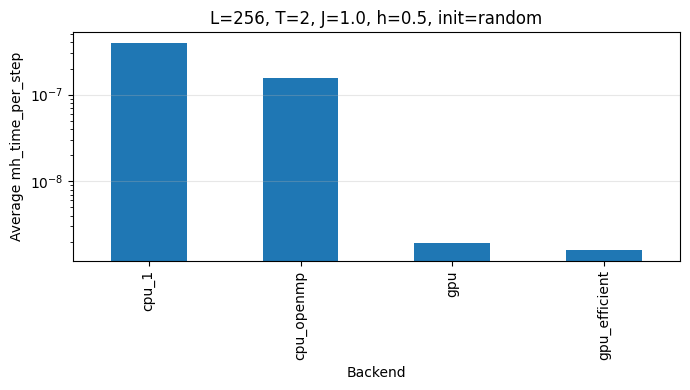

In [45]:
plot_avg_performance(
    df,
    L=256,
    T=2,
    J=1.0,
    h=0.5,
    init_type="random"
)


In [40]:
def plot_time_vs_L(
    df: pd.DataFrame,
    *,
    T=None,
    J=None,
    h=None,
    init_type=None,
    n_steps=None,
    metric="mh_time_per_step",
    backends=("cpu_1", "cpu_openmp", "gpu", "gpu_efficient"),
    error="sem",   # "std" or "sem"
    logy=True,
):
    """
    Plot average time as a function of L with error bars, split by backend.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    T, J, h, init_type, n_steps : optional
        Fixed parameters used to filter the dataframe.
    metric : str
        Time metric to average (default: 'mh_time_per_step').
    backends : tuple
        Backends to plot.
    error : str
        Error bar type: "std" (standard deviation) or "sem" (standard error).
    logy : bool
        Use logarithmic y-scale.
    """

    # --- filtering ---
    mask = pd.Series(True, index=df.index)

    if T is not None:
        mask &= df["T"] == T
    if J is not None:
        mask &= df["J"] == J
    if h is not None:
        mask &= df["h"] == h
    if init_type is not None:
        mask &= df["init_type"] == init_type
    if n_steps is not None:
        mask &= df["n_steps"] == n_steps

    df_filt = df.loc[mask & df["backend"].isin(backends)]

    if df_filt.empty:
        raise ValueError("No data left after filtering.")

    # --- aggregation ---
    grouped = (
        df_filt
        .groupby(["backend", "L"])[metric]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    if error == "sem":
        grouped["err"] = grouped["std"] / np.sqrt(grouped["count"])
    elif error == "std":
        grouped["err"] = grouped["std"]
    else:
        raise ValueError("error must be 'std' or 'sem'")

    # --- plotting ---
    plt.figure(figsize=(7, 4))

    for backend in backends:
        sub = grouped[grouped["backend"] == backend]
        if sub.empty:
            continue

        sub = sub.sort_values("L")

        plt.errorbar(
            sub["L"],
            sub["mean"],
            yerr=sub["err"],
            marker="o",
            capsize=3,
            label=backend,
        )

    plt.xlabel("L")
    plt.ylabel(f"Average {metric}")

    title_parts = []
    for name, val in [("T", T), ("J", J), ("h", h), ("init", init_type)]:
        if val is not None:
            title_parts.append(f"{name}={val}")

    title = "Performance scaling with L"
    if title_parts:
        title += "\n" + ", ".join(title_parts)

    plt.title(title)

    if logy:
        plt.yscale("log")

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [41]:
#list all unique L values
unique_L = df['L'].unique()
print("Unique L values in the dataset:", unique_L)

Unique L values in the dataset: [  16   64  128  192  256  320  384  448  512  640  768  896 1024 1536
 2048 2560 3072 3548 4096]


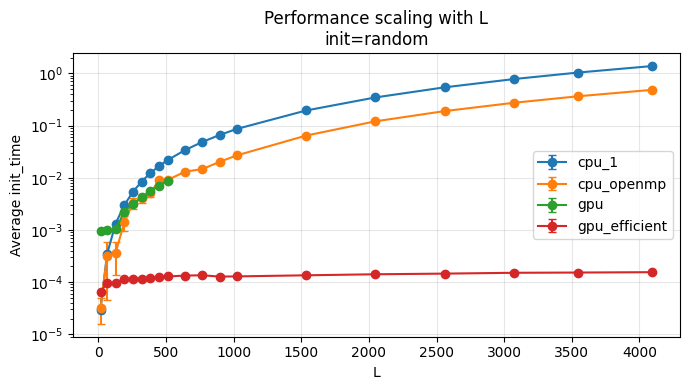

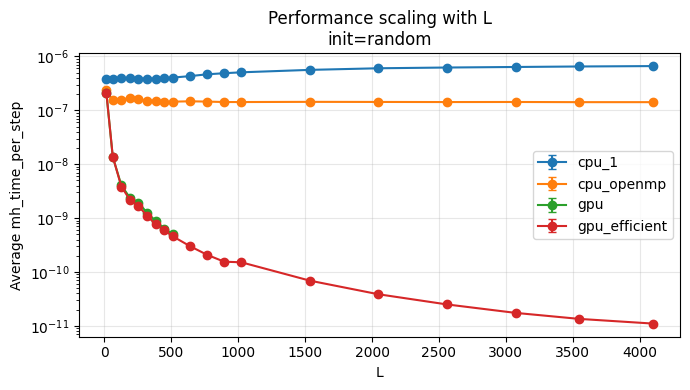

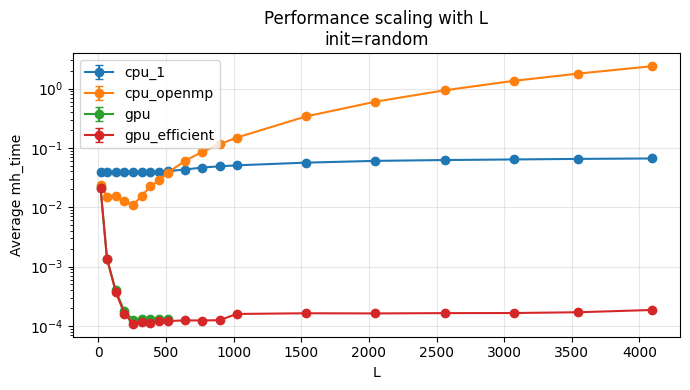

In [42]:
plot_time_vs_L(
    df,
    # T=10.0,
    # J=1.0,
    # h=0.5,
    init_type="random",
    metric = "init_time", logy = True
)

plot_time_vs_L(
    df,
    # T=10.0,
    # J=1.0,
    # h=0.5,
    init_type="random",
    metric = "mh_time_per_step",
    logy= True
)


plot_time_vs_L(
    df,
    # T=10.0,
    # J=1.0,
    # h=0.5,
    init_type="random",
    metric = "mh_time",
    logy= True
)
